# Linear elasticity

*This work is adapted from the FEniCS tutorial: https://fenicsproject.org/pub/tutorial/html/._ftut1008.html#ftut:elast*

Having studied a few scalar-valued problems, we now move on to a vector-valued problem.  The equations of linear elasticity.  Here, we'll treat the isotropic case.

For small deformations, the governing equation is:

$$ -\nabla \cdot \sigma = f \text{ in } \Omega, $$
with
$$ \DeclareMathOperator{\Tr}{Tr}
\text{the stress tensor}\quad \sigma := \lambda \Tr(\epsilon)\mathbb{I} + 2\mu\epsilon\\
\text{and the symmetric strain rate tensor}\quad   \epsilon := \frac{1}{2}\left(\nabla u + (\nabla u)^T\right), $$
where $u$ is the unknown vector displacement field, and $\mu$ and $\lambda$ are the Lamè parameters.

As before, the variational formulation consists of multiplying by a test function in some suitable finite element space, $v \in V$, and integrating.  Note that this time, the solution $u$, and hence the test space $V$ are *vector*-valued (so multiplication actually means taking the inner product).

We obtain

$$ -\int_\Omega (\nabla \cdot \sigma)\cdot v\,\mathrm{d}x = \int_\Omega f \cdot v\,\mathrm{d}x. $$

Since $\sigma$ is actually a function of derivatives of $u$, we must integrate this term by parts, resulting in

$$ \int_\Omega \sigma : \nabla v\,\mathrm{d} x - \int_\Gamma (\sigma \cdot n)\cdot v\,\mathrm{d} s. = \int_\Omega f \cdot v\,\mathrm{d}x.$$

We also need to specify boundary conditions.  We can do so either by prescribing the displacement $u$ on the boundary, or the *traction* $\sigma \cdot n$.  The former is a *strong* or *Dirichlet* condition, the latter a *weak* or *Neumann* condition.

Let us decide on a concrete setting.  We will solve for the displacement of a beam under its own weight clamped at one end.  That is, we will take $\Omega = [0, L] \times [0, W]$, we set $u = (0, 0)$ on $\Gamma_D$, the plane $x = 0$.  On all other boundaries, we have traction-free conditions.

We start, as usual, by import Firedrake and defining a mesh

In [1]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
from firedrake.pyplot import triplot

plt.rcParams['figure.figsize'] = (11, 4)

In [2]:
from firedrake import *
length = 1
width = 0.2
mesh = RectangleMesh(40, 20, length, width)

We need a function space for the solution variable $u$, this space is vector valued, so we use a `VectorFunctionSpace`.  By default, this constructs a space where the vectors have as many components as the *geometric* dimension of the mesh (two in this case).

In [3]:
V = VectorFunctionSpace(mesh, "Lagrange", 1)

We need a boundary condition object for $\Gamma_D$.

In [4]:
bc = DirichletBC(V, Constant([0, 0]), 1)

Now let's define the material parameters.  The deformation due to gravity can be obtained by setting the load vector $f = (0, -\rho g)$ where $\rho$ is the material density and $g$ the acceleration due to gravity.  We'll choose $\rho = 0.01$, and $g = 1$.

In [5]:
rho = Constant(0.01)
g = Constant(1)
f = as_vector([0, -rho*g])
mu = Constant(1)
lambda_ = Constant(0.25)
Id = Identity(mesh.geometric_dimension()) # 2x2 Identity tensor

Now we'll define functions that construct the symbolic expressions for the stress and strain.

In [6]:
def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)

def sigma(u):
    return lambda_*div(u)*Id + 2*mu*epsilon(u)

The variational problem can now be solved. Passing the solver parameter `"ksp_monitor": None` tells PETSc to print the progress of the linear solver to screen. Firedrake uses a direct solver by default, so it should converge in one iteration.

In [7]:
u = TrialFunction(V)
v = TestFunction(V)
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx

uh = Function(V)
solve(a == L, uh, bcs=bc, solver_parameters={"ksp_monitor": None})

    Residual norms for firedrake_0_ solve.
    0 KSP Residual norm 6.916415658096e-05 
    1 KSP Residual norm 6.282724610765e-15 


## Visualising the solution
We solved the equations in *displacement* formulation.  That is, the $u_h$ we obtain is a perturbation to the original coordinate field of the mesh.  If we want to view the output, we can either use the original mesh, or we can create a new mesh with the displaced coordinates: $\hat{X} = X + u_h$.

In [8]:
displaced_coordinates = interpolate(SpatialCoordinate(mesh) + uh, V)
displaced_mesh = Mesh(displaced_coordinates)

This created a new mesh with a coordinate field provided by `displaced_coordinates` that nevertheless shares a *topology* with the original, regular, mesh.  We could, if we wanted to, go ahead and solve variational problems on this new mesh, however, we've only done this so we can see the elastic deformation.
Here we're using the matplotlib API for [Axes](https://matplotlib.org/api/axes_api.html) objects to make the horizontal and vertical axes equally spaced.

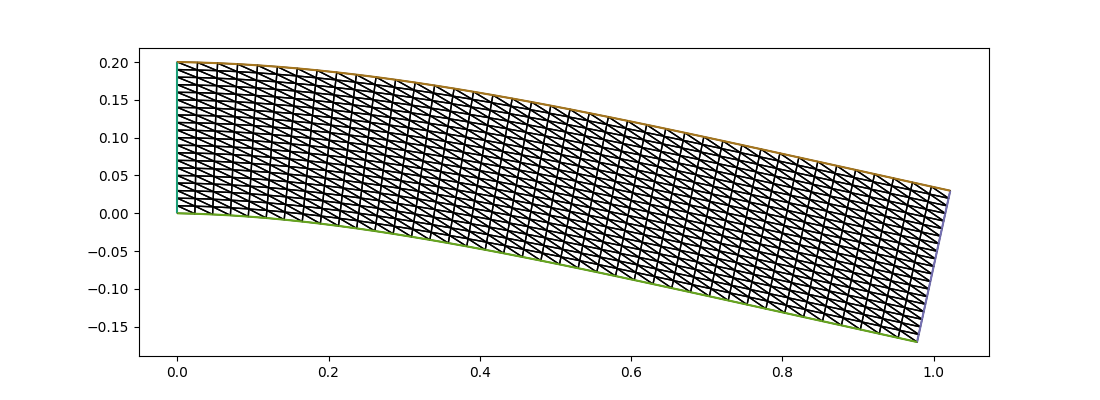

In [9]:
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots()
triplot(displaced_mesh, axes=axes)
axes.set_aspect("equal");

# Exercises

Modify the problem so that the material density $\rho$ is not constant, but rather varies in space.  For example, you could try setting $\rho(x, y) = 0.01 + xy$.  That is, the material gets denser the futher away from the clamped end you get.

- Hint 1: The values for the components of `as_vector` can be arbitrary UFL expressions.
- Hint 2: You can get symbolic expressions for the coordinates with `x, y = SpatialCoordinate(mesh)`.

# Solving bigger problems

Up to now, we've only really solved quite small problems, and therefore haven't really had to worry about tuning the solver. As we increase the size of the problem we're solving, the direct solver approach will no longer be good enough.  Firedrake uses [PETSc](http://www.mcs.anl.gov/petsc) to provide solvers, and uses PETSc solver parameters to control them.

Let's dive straight in.  We'll write a function that solves the same elasticity problem, but takes parameters for the number of cells in the mesh, as well as a dictionary of solver options.

In [10]:
def solve_elasticity(nx, ny, options=None, **kwargs):
    length = 1
    width = 0.2
    mesh = RectangleMesh(nx, ny, length, width)
    V = VectorFunctionSpace(mesh, "Lagrange", 1)
    rho = Constant(0.01)
    g = Constant(1)
    f = as_vector([0, -rho*g])
    mu = Constant(1)
    lambda_ = Constant(0.25)
    Id = Identity(mesh.geometric_dimension()) # 2x2 Identity tensor
    
    bc = DirichletBC(V, Constant([0, 0]), 1)
    u = TrialFunction(V)
    v = TestFunction(V)
    a = inner(sigma(u), epsilon(v))*dx
    L = dot(f, v)*dx

    uh = Function(V)
    solve(a == L, uh, bcs=bc, solver_parameters=options, **kwargs)
    return uh

The problem is solved with a Krylov method, so let's limit ourselves to just 100 iterations.  Moreover, it is symmetric positive definite, so let's use the conjugate gradient method.
Let's not worry about preconditioning for now and set `"pc_type": "none"`.

In [11]:
# NBVAL_RAISES_EXCEPTION
uh = solve_elasticity(100, 100, options={"ksp_max_it": 100, "ksp_type": "cg", "pc_type": "none"})

ConvergenceError: Nonlinear solve failed to converge after 0 nonlinear iterations.
Reason:
   DIVERGED_LINEAR_SOLVE

Oh no!  We didn't get a solution.  This is because the linear system is ill conditioned.  Fortunately, good preconditioning strategies exist for elasticity problems.  For example, smoothed aggregation multigrid.  We can access PETSc's implementation of this scheme, GAMG, by specifying the appropriate preconditioner. In order to reduce the verbosity of the linear solver progress monitoring, we use `"ksp_converged_reason": None`, instead of `"ksp_monitor": None`.

In [12]:
uh = solve_elasticity(200, 200, options={"ksp_type": "cg", 
                                         "ksp_max_it": 100, 
                                         "pc_type": "gamg",
                                         "pc_gamg_aggressive_square_graph": None,
                                         "pc_gamg_mis_k_minimum_degree_ordering": True,
                                         "mg_levels_pc_type": "sor",
                                         "mat_type": "aij",
                                         "ksp_converged_reason": None})

  Linear firedrake_2_ solve converged due to CONVERGED_RTOL iterations 81


This is still not ideal, taking quite a few iterations.  It turns out that for smoothed aggregation to work well, the preconditioner needs access to the near nullspace of the operator.  That is, the null modes of the operator if no Dirichlet conditions were applied.  For elasticity, these are the rigid body modes of translation and rotation.  We must build these and supply them to the solver.  To do so, we must create a `VectorSpaceBasis`:

In [13]:
def solve_elasticity(nx, ny, options=None, **kwargs):
    length = 1
    width = 0.2
    mesh = RectangleMesh(nx, ny, length, width)
    V = VectorFunctionSpace(mesh, "CG", 1)
    rho = Constant(0.01)
    g = Constant(1)
    f = as_vector([0, -rho*g])
    mu = Constant(1)
    lambda_ = Constant(0.25)
    Id = Identity(mesh.geometric_dimension()) # 2x2 Identity tensor
    def epsilon(u):
        return 0.5*(grad(u) + grad(u).T)

    def sigma(u):
        return lambda_*div(u)*Id + 2*mu*epsilon(u)    
    bc = DirichletBC(V, Constant([0, 0]), 1)
    u = TrialFunction(V)
    v = TestFunction(V)
    a = inner(sigma(u), epsilon(v))*dx
    L = dot(f, v)*dx

    # create rigid body modes
    x, y = SpatialCoordinate(mesh)
    b0 = Function(V)
    b1 = Function(V)
    b2 = Function(V)
    b0.interpolate(Constant([1, 0]))
    b1.interpolate(Constant([0, 1]))
    b2.interpolate(as_vector([-y, x]))
    nullmodes = VectorSpaceBasis([b0, b1, b2])
    # Make sure they're orthonormal.
    nullmodes.orthonormalize()
    uh = Function(V)
    solve(a == L, uh, bcs=bc, solver_parameters=options, near_nullspace=nullmodes)
    return uh

With this done, the problem is solved in a reasonably small number of Krylov iterations.

In [14]:
uh = solve_elasticity(200, 200, options={"ksp_type": "cg", 
                                         "ksp_max_it": 100, 
                                         "pc_type": "gamg",
                                         "pc_gamg_aggressive_square_graph": None,
                                         "pc_gamg_mis_k_minimum_degree_ordering": True,
                                         "mat_type": "aij",
                                         "ksp_converged_reason": None})

  Linear firedrake_3_ solve converged due to CONVERGED_RTOL iterations 36


## Exercise

Study what happens to the number of iterations for this last setup as you change the mesh resolution.  Try, perhaps, 10, 50, 100, and 200.